In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time


497


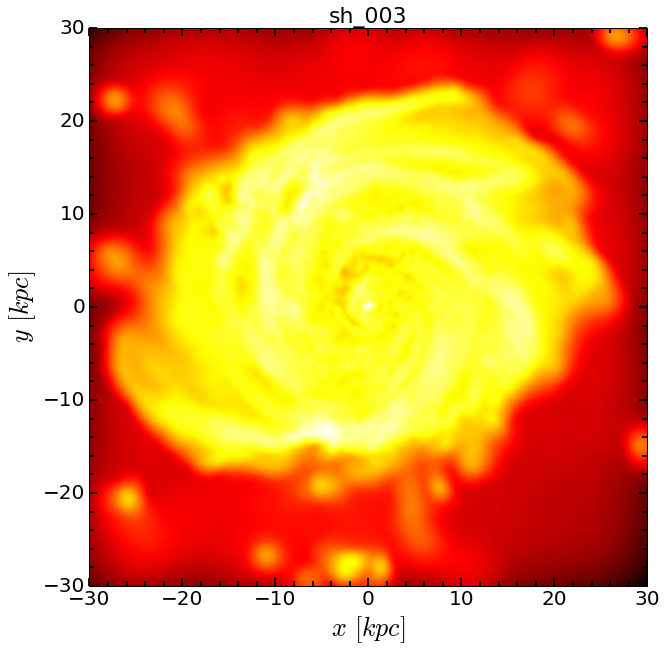

In [8]:
#Graficos de Densidad de Gas

####PRUEBA PILOTO
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    a = snap['subhalo_000/Time'].value
    z = (a0/a)-1
    t = conv(z, h, omega_lambda, omega_matter)
    
    print isnap
    for i in range(2,3):
        pgas = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Gas/Velocities'].value
        masa = snap['subhalo_0'+ str('%s'%vector[i]) +'/Gas/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
#---------paso las coordenadas respecto al centro de la galaxia-------
        xgas = (pgas[:,0]-cm[0])/h
        ygas = (pgas[:,1]-cm[1])/h
        zgas = (pgas[:,2]-cm[2])/h
        r = np.sqrt(xgas**2+ygas**2+zgas**2)
        
#---------------masas------------------------------------------        
        masa = masa/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
##esto sirve si quiero hacer una submuestra de mi conjunto de datos
       
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa[veloc]*vel[veloc,0])/sum(masa[veloc])
        vycm = sum(masa[veloc]*vel[veloc,1])/sum(masa[veloc])
        vzcm = sum(masa[veloc]*vel[veloc,2])/sum(masa[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
# utilizo una matriz de rotacion de modo que el plano xy coincida aprox con el plano del disco
# rot.rot, el primer rot es como yo le llamo arriba cuando importo, el segundo rot tiene que ver
#con como se llama la funcion adentro del archivo rotation
        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa,xgas,ygas,zgas,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xgas + e1y*ygas + e1z*zgas
        yn = e2x*xgas + e2y*ygas + e2z*zgas
        zn = e3x*xgas + e3y*ygas + e3z*zgas
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

#---------------------generador del gráfico-----------------
        rl= 30    
        corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))
         
#-----rango que tiene la escala  de colores-----
        vmin=0
        vmax=9
        
# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='hot'
    
#-----grafico-----------
        fig=plt.figure(1,figsize=(10,10))
        #fig.subplots_adjust(bottom=1, left =1, right = 1, top = 1)
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        
        ax=fig.add_subplot(111)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        ax.set_title('sh_0'+ str('%s'%vector[i]), fontsize=22)
        #plt.axis('off')
        plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        ax.minorticks_on()
        #ax.set_yticklabels([])
        #ax.set_xticklabels([])
        ax.tick_params( labelsize=20)
        ax.tick_params('both', length=5, width=1.8,which='minor')
        ax.tick_params('both', length=8, width=1.8,which='major')
        #plt.text(22, 28, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='center', va='top') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
        #             ha='center', va='center', 
        #            arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))
        
        #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')
        

        #fig.savefig('/home/ornela/python/Gas1/M31_3/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        fig.savefig('/home/ornela/python/Gas1/gas_'+str('%s'%vector[i])+'.png', dpi = 100)
        plt.show()
        #plt.clf()